In [2]:
import sys
sys.path.insert(0, '/Users/nierenbe/repositories/07_23_25/trikde')
from trikde.pdfs import DensitySamples, IndependentLikelihoods
from trikde.triangleplot import TrianglePlot
import numpy as np
import matplotlib.pyplot as plt

### Make some mock data 

In [3]:
means = [0.55, 0.8, 0.45]
sigma_11 = 0.15 ** 2
sigma_22 = 0.2 ** 2
sigma_33 = 0.12 ** 2
sigma_12 = - (0.09 ** 2)
sigma_23 = 0.08 ** 2
sigma_13 = 0.07 ** 2

cov = np.array([[sigma_11, sigma_12, sigma_13], 
       [sigma_12, sigma_22, sigma_23], 
       [sigma_13, sigma_23, sigma_33]])
nsamples = 1000
samples = np.random.multivariate_normal(means, cov, nsamples)
assert np.linalg.det(cov) > 0

param_names = ['p1', 'p2', 'p3']
weight_list = None
param_ranges = [[0., 1.25], [0., 1.25], [0., 1.25]]
nbins = 20
use_kde = False
density_samples_no_kde = DensitySamples(samples, param_names, weight_list, param_ranges, 
                                        nbins=nbins, use_kde=None)
density_samples_with_kde = DensitySamples(samples, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde='GAUSSIAN_NO_COV')
# the kernel density likelihood will in general depend on the bandwidth; it is difficult to know a priori what
# value is appropriate, especially for non-gaussian distributions
density_samples_with_kde_2 = DensitySamples(samples, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde='GAUSSIAN_NO_COV', bandwidth_scale=0.1)

independent_densities_no_kde = IndependentLikelihoods([density_samples_no_kde])
independent_densities_with_kde = IndependentLikelihoods([density_samples_with_kde])
independent_densities_with_kde_2 = IndependentLikelihoods([density_samples_with_kde_2])

## Plot the distributions

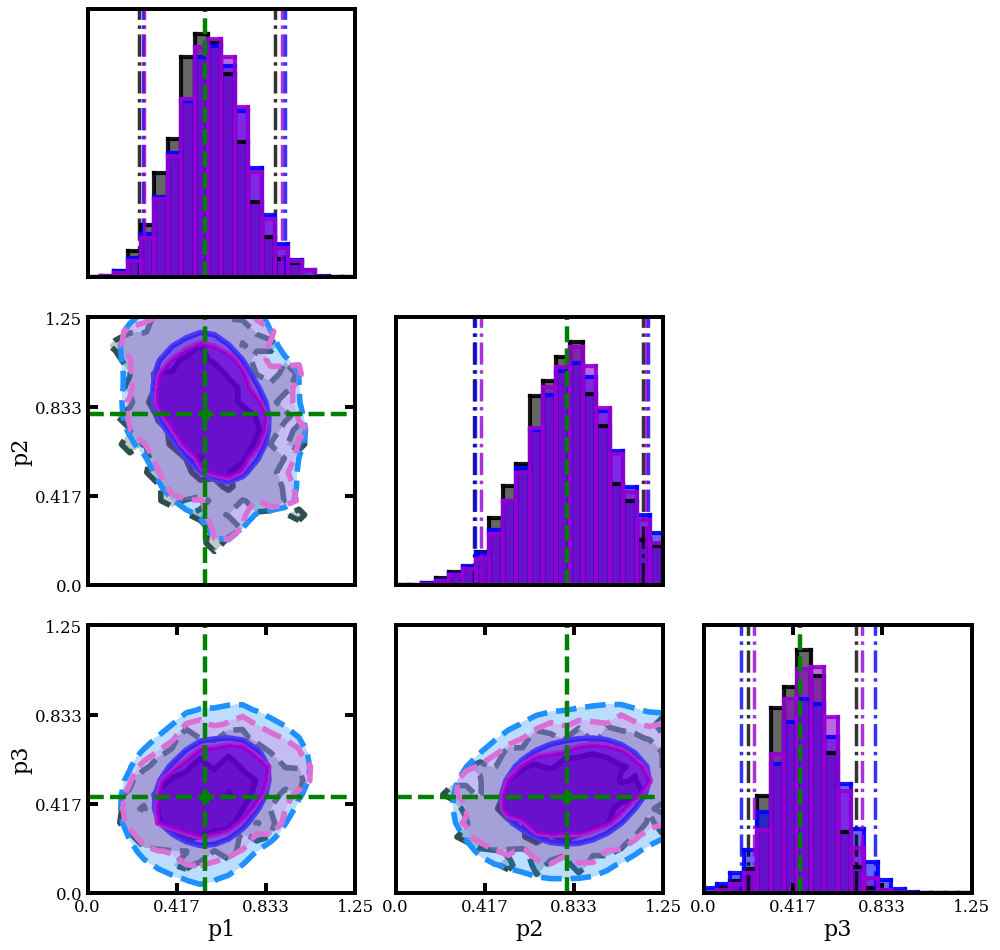

In [4]:
truths = {'p1': means[0], 'p2': means[1], 'p3': means[2]}
pdf_list = [independent_densities_no_kde, 
                        independent_densities_with_kde, 
                        independent_densities_with_kde_2]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths)

## Multiplying indepdent pdfs

The DensitySamples class represents a single independent likelihood. If a list of these classes is passed to IndepdendentLikelihoods, then each instance of DensitySamples will be interpreted as an independent pdf and they will be multiplied together

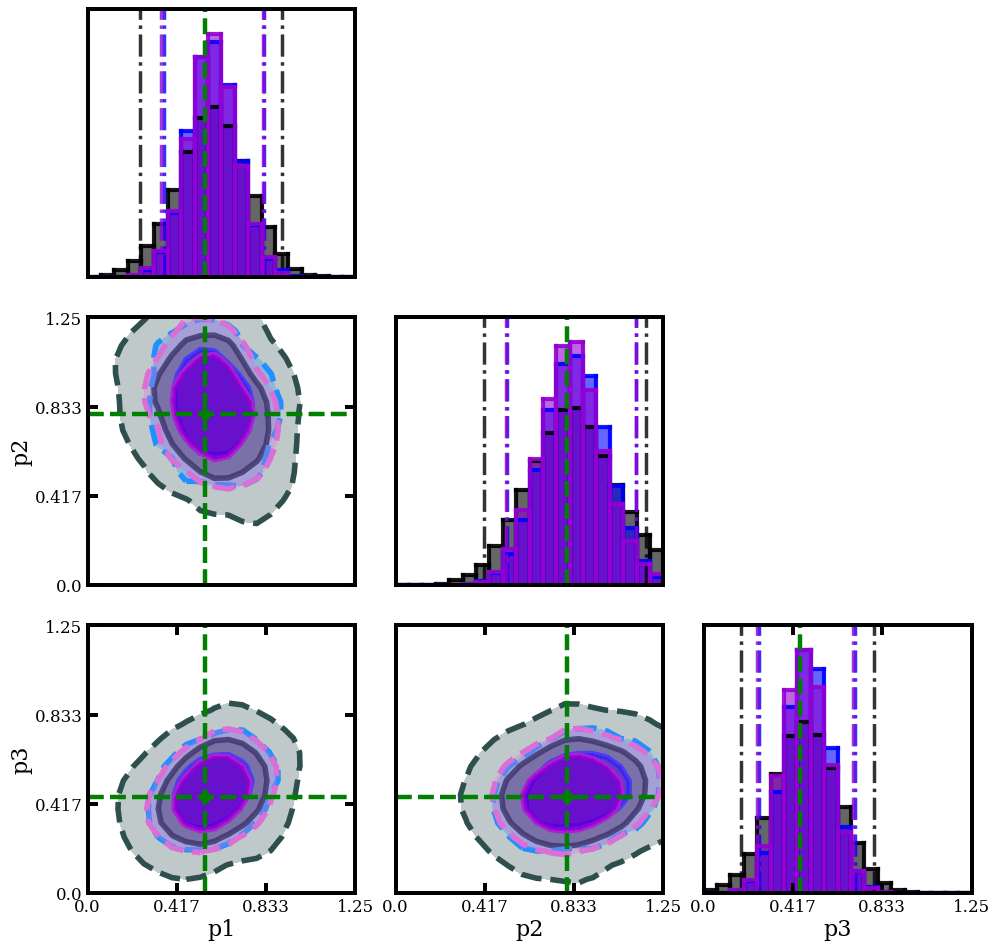

In [5]:
nsamples = 1000

inv = np.linalg.inv(cov)
cov_product = np.linalg.inv(inv)
samples = np.random.multivariate_normal(means, cov_product, nsamples)
pdf = DensitySamples(samples, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde='GAUSSIAN')

inv = 2 * np.linalg.inv(cov)
cov_product = np.linalg.inv(inv)
samples_product = np.random.multivariate_normal(means, cov_product, nsamples)
pdf_product = DensitySamples(samples_product, param_names, weight_list, param_ranges, nbins=nbins, 
                                          use_kde='GAUSSIAN')

independent_likelihood_single = IndependentLikelihoods([pdf])
independent_likelihood_product_from_samples = IndependentLikelihoods([pdf_product])
independent_likelihood_product_from_pdfs = IndependentLikelihoods([pdf, # we pass it twice and it gets multiplied
                                                                    pdf])

pdf_list = [independent_likelihood_single, 
            independent_likelihood_product_from_samples, 
            independent_likelihood_product_from_pdfs]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths)

### Multiplying and diving likelihood classes 

The independent likelihoods class knows about multiplication and division. This is a straightforward way to combine several statistically independent inferences 

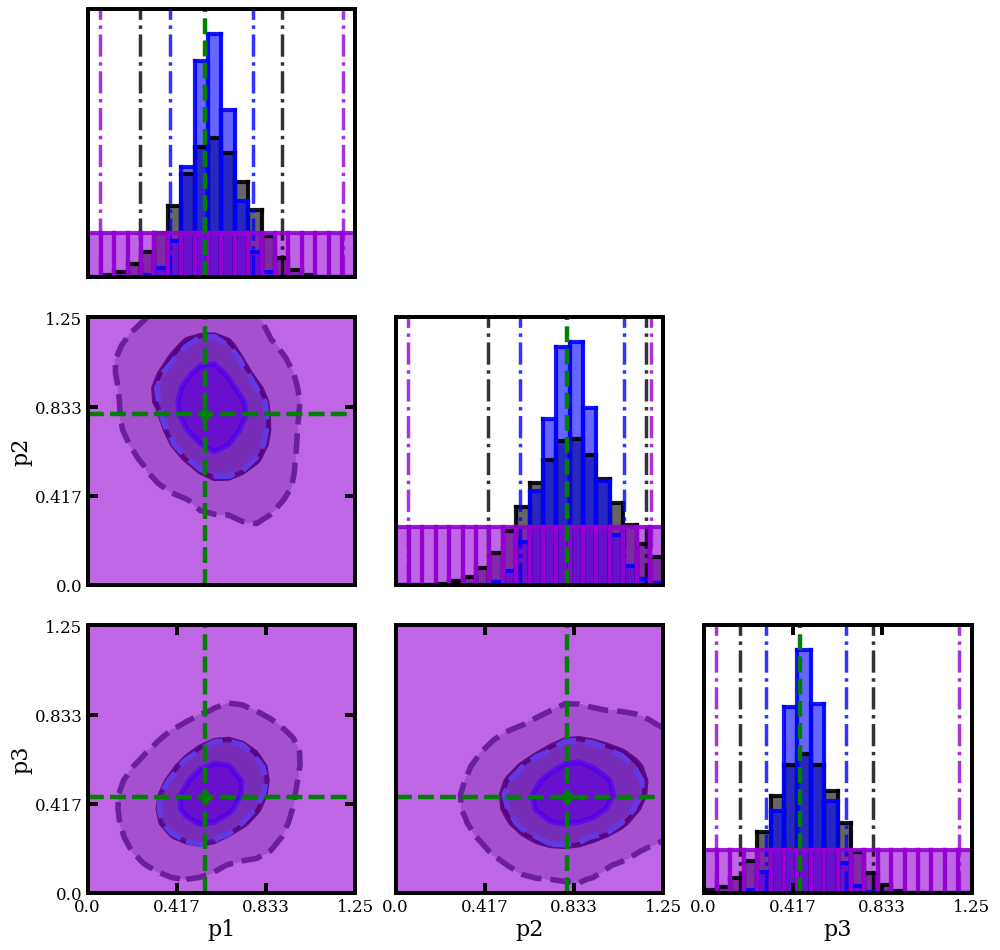

In [6]:
independent_likelihood_single = IndependentLikelihoods([pdf])
independent_likelihood_single_cubed = independent_likelihood_single * independent_likelihood_single * independent_likelihood_single
uniform_distribution = independent_likelihood_single / independent_likelihood_single # equals 1

pdf_list = [independent_likelihood_single, 
            independent_likelihood_single_cubed, 
            uniform_distribution]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths)

### Visualize distributions 

At the end of the day this package is a fancy way of visualizing multi-dimensional histograms. You can plot the histograms themselves by setting filled_contours = False

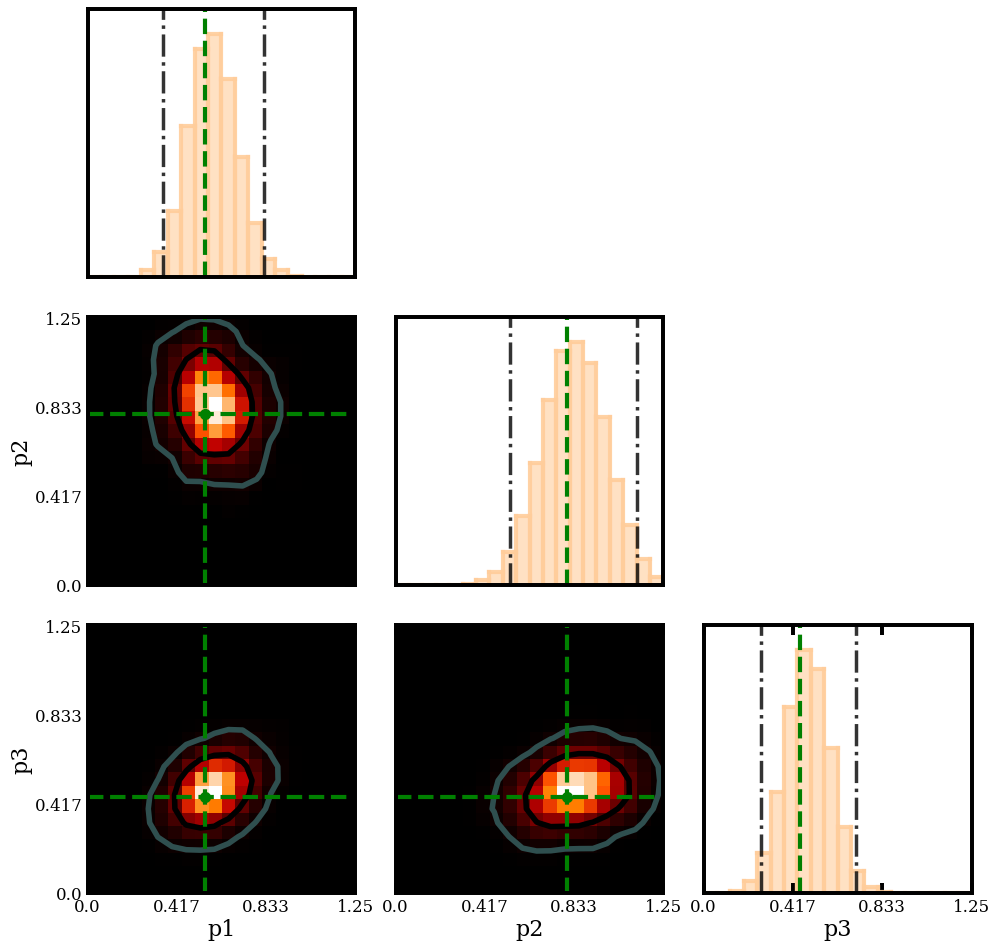

In [7]:
fig = plt.figure(1)
pdf_list = [independent_likelihood_product_from_samples]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths, filled_contours=False)
plt.show()

### Importance sampling
You can re-weight samples by specifying weights in the DensitySamples class (default is None). The weights must be the same length as the samples array (i.e. one weight per sample)

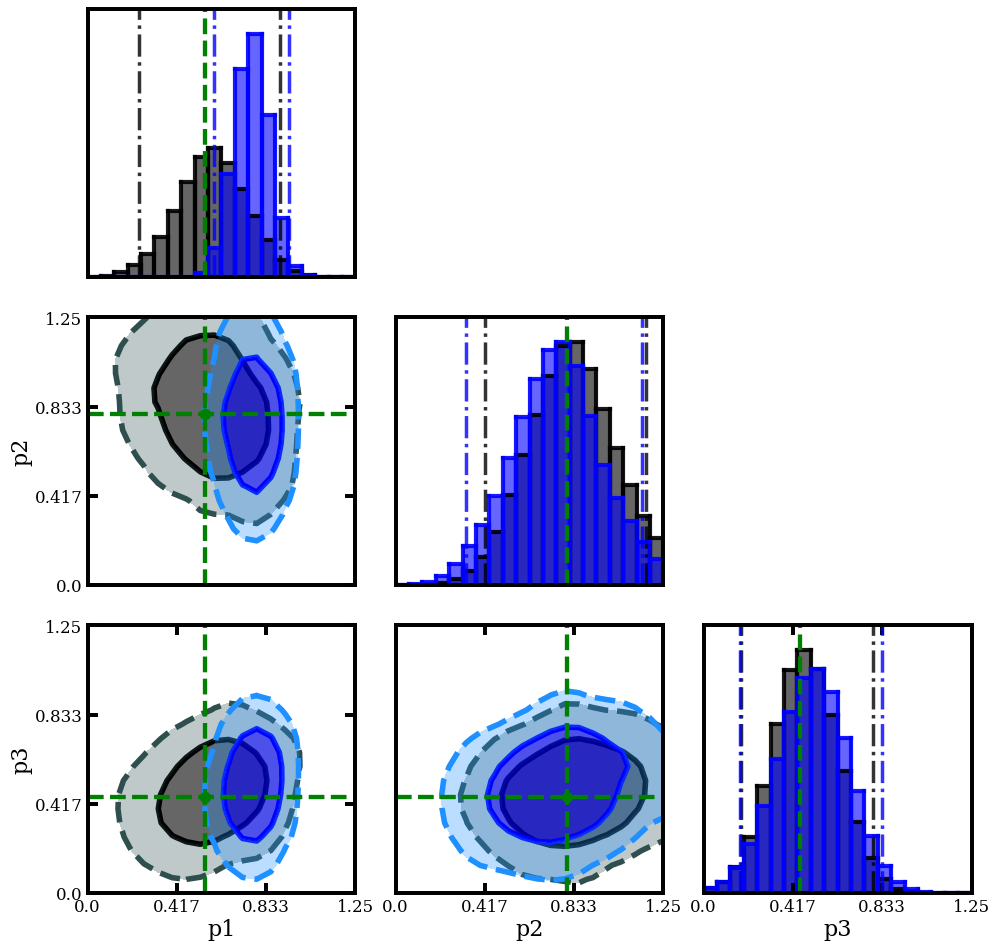

In [8]:
mu, s = means[0] + 0.2, 0.05 #offset the weights from the mean
importance_weights = np.exp(-0.5 * (mu - samples[:,0])**2 / s**2)

density_samples_with_kde = DensitySamples(samples, param_names, importance_weights, param_ranges, nbins=nbins, 
                                          use_kde='GAUSSIAN')
independent_densities_with_kde = IndependentLikelihoods([density_samples_with_kde])

triplot = TrianglePlot([independent_likelihood_single, 
                        independent_densities_with_kde])
axes_list = triplot.make_triplot(truths=truths)

### Visualization and plotting 

The most direct way to manipulate the appearence of the triangle plot (i.e. set axis labels, tick locations and labels, add legends, etc) is to work with the list of axes returned from the make_triplot function 

Text(0, 0.5, 'I changed these ticks')

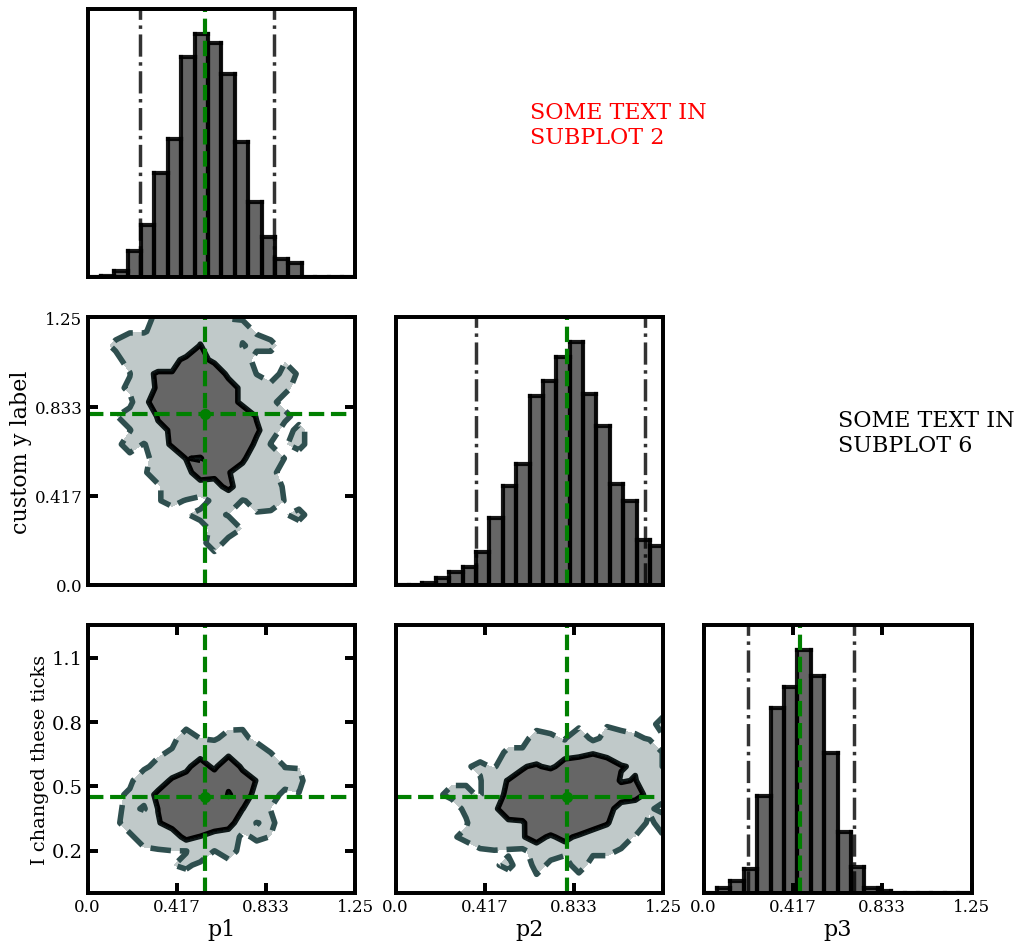

In [9]:
truths = {'p1': means[0], 'p2': means[1], 'p3': means[2]}
pdf_list = [independent_densities_no_kde]
triplot = TrianglePlot(pdf_list)
axes_list = triplot.make_triplot(truths=truths)

# triplot.make_triplot returns a list of the subplots, which can be individually manipulated
axes_list[1].annotate('SOME TEXT IN\nSUBPLOT 2', xy=(0.5, 0.5), xycoords='axes fraction', color='r', fontsize=16)
axes_list[5].annotate('SOME TEXT IN\nSUBPLOT 6', xy=(0.5, 0.5), xycoords='axes fraction', color='k', fontsize=16)
axes_list[3].set_ylabel('custom y label')

axes_list[6].set_yticks([0.2, 0.5, 0.8, 1.1])
axes_list[6].set_yticklabels([0.2, 0.5, 0.8, 1.1], fontsize=14)
axes_list[6].set_ylabel('I changed these ticks', fontsize=14)

### Fancy parameter names and tick properties 

One can also specify functions that perform these actions automatically 

In [10]:
def param_name_transformation(param_name):
    # to Latex
    if param_name == 'p1':
        return r'$p_1$'
    elif param_name == 'p2':
        return r'$p_2$'
    else:
        return param_name
        
def label_axes():

    settings = {}
    settings['p1'] = {}
    settings['p2'] = {}
    settings['p3'] = {}
    settings['p1']['tick_locations'] = [0.2, 0.5, 0.8, 1.1]
    settings['p1']['tick_labels'] = settings['p1']['tick_locations']
    settings['p2']['tick_locations'] = [0.25, 0.55, 0.85, 1.15]
    settings['p2']['tick_labels'] = settings['p2']['tick_locations']
    settings['p3']['tick_locations'] = [0.1, 0.4, 0.6, 1.0]
    settings['p3']['tick_labels'] = settings['p3']['tick_locations']
    return settings



Text(0, 0.5, 'custom y label')

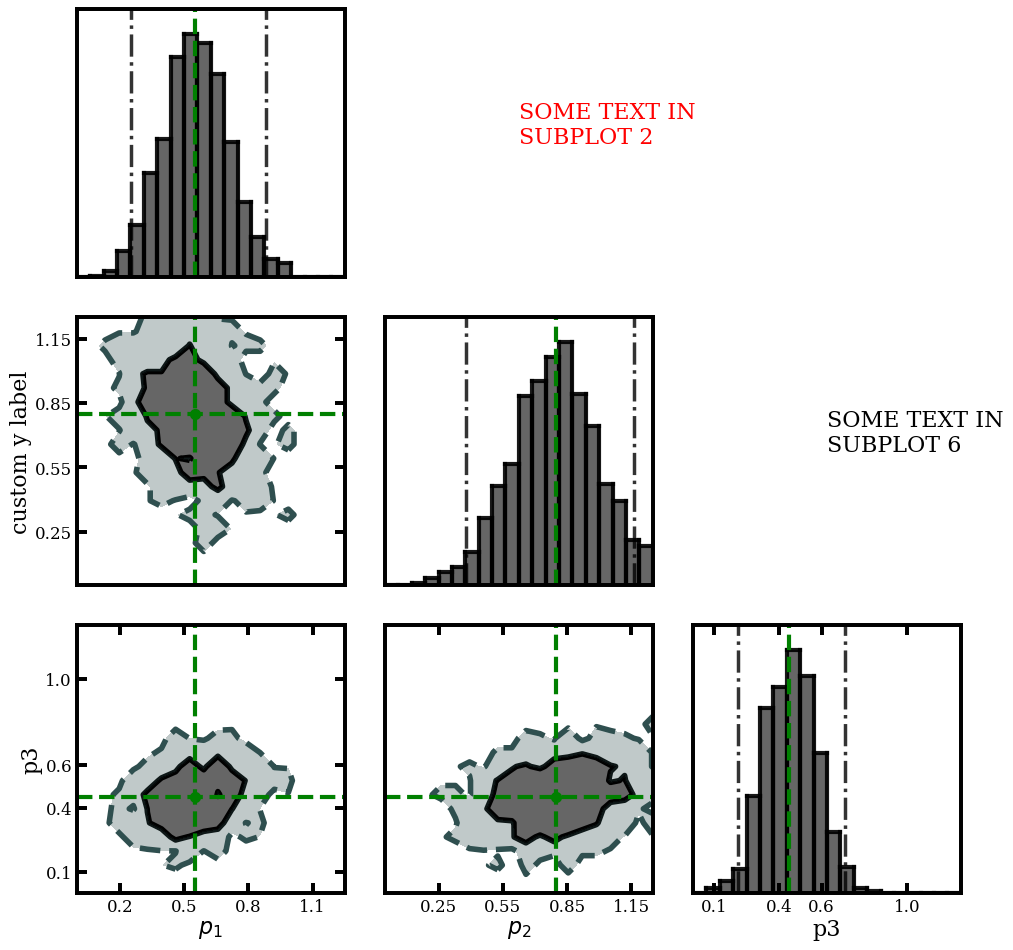

In [11]:
truths = {'p1': means[0], 'p2': means[1], 'p3': means[2]}
pdf_list = [independent_densities_no_kde]

ticks_and_labels_settings = label_axes() # create the dictionary 
triplot = TrianglePlot(pdf_list,
                      param_name_transformation=param_name_transformation, # pass in the function
                      ticks_and_labels_settings=ticks_and_labels_settings # pass in the dictionary 
                      )
axes_list = triplot.make_triplot(truths=truths)

# triplot.make_triplot returns a list of the subplots, which can be individually manipulated
axes_list[1].annotate('SOME TEXT IN\nSUBPLOT 2', xy=(0.5, 0.5), xycoords='axes fraction', color='r', fontsize=16)
axes_list[5].annotate('SOME TEXT IN\nSUBPLOT 6', xy=(0.5, 0.5), xycoords='axes fraction', color='k', fontsize=16)
axes_list[3].set_ylabel('custom y label')


### One-sided confidence intervals 

Sometimes it makes sense to quote a 1-sided confidence interval instead of a two-sided one 

In [14]:
from trikde.pdfs import InterpolatedLikelihood

interp_likelihood = InterpolatedLikelihood(independent_densities_no_kde, param_names, param_ranges, extrapolate=True)
# calling this class at a point gives the likelihood (relative to the most probable point)
point = (0.5, 0.8, 0.1)
print(interp_likelihood(point))

# one can draw samples from the pdf like this
n_samples = 1000
joint_samples = interp_likelihood.sample(n_samples)

# 90% confidence interval for parameter 1
samples = joint_samples[:,0]
samples_sorted = samples[np.argsort(samples)]
limit_95_percent = samples_sorted[950]
print('95% of samples are below: ', limit_95_percent)

[array([0.03125, 0.09375, 0.15625, 0.21875, 0.28125, 0.34375, 0.40625,
       0.46875, 0.53125, 0.59375, 0.65625, 0.71875, 0.78125, 0.84375,
       0.90625, 0.96875, 1.03125, 1.09375, 1.15625, 1.21875]), array([0.03125, 0.09375, 0.15625, 0.21875, 0.28125, 0.34375, 0.40625,
       0.46875, 0.53125, 0.59375, 0.65625, 0.71875, 0.78125, 0.84375,
       0.90625, 0.96875, 1.03125, 1.09375, 1.15625, 1.21875]), array([0.03125, 0.09375, 0.15625, 0.21875, 0.28125, 0.34375, 0.40625,
       0.46875, 0.53125, 0.59375, 0.65625, 0.71875, 0.78125, 0.84375,
       0.90625, 0.96875, 1.03125, 1.09375, 1.15625, 1.21875])]
0.001875000000000006
sampling.... 10.0%
sampling.... 20.0%
sampling.... 30.0%
sampling.... 40.0%
sampling.... 50.0%
sampling.... 60.0%
sampling.... 70.0%
sampling.... 80.0%
sampling.... 90.0%
95% of samples are below:  0.8044535703644244


Text(0, 0.5, 'custom y label')

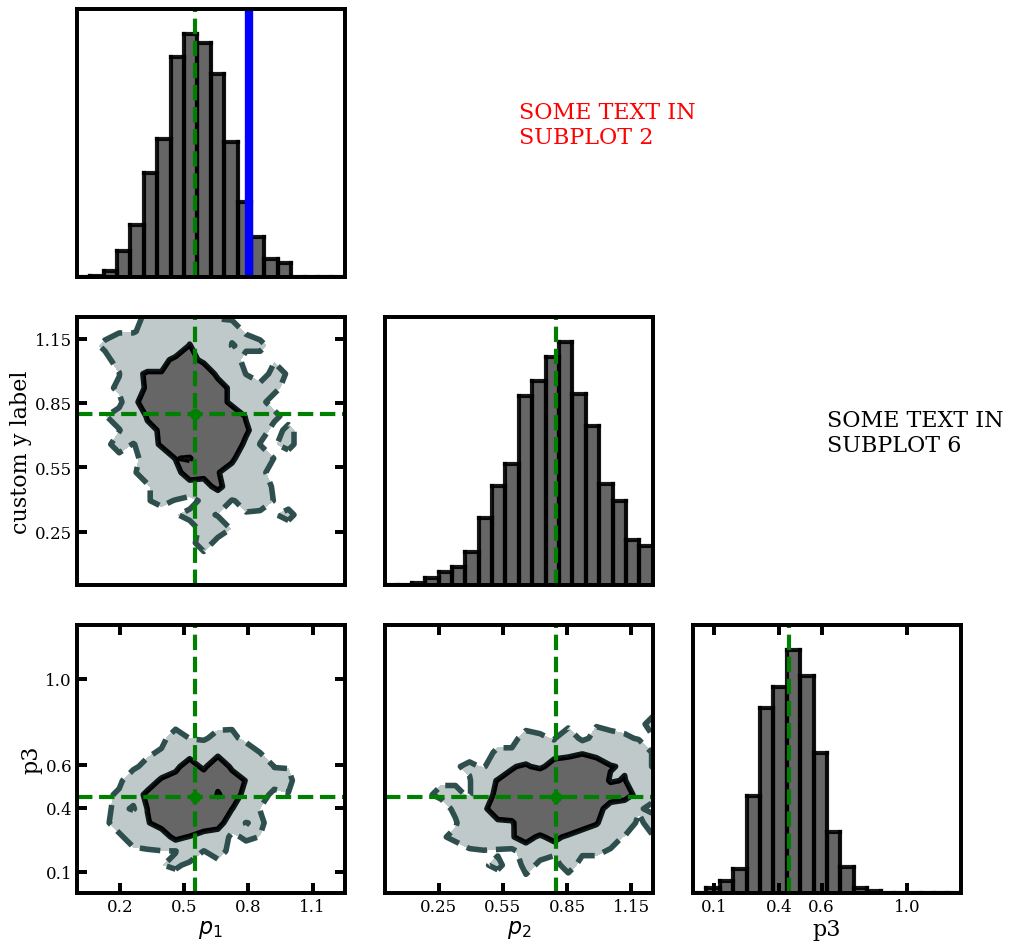

In [15]:
show_intervals = False

triplot = TrianglePlot(pdf_list,
                      param_name_transformation=param_name_transformation,
                      ticks_and_labels_settings=ticks_and_labels_settings)
axes_list = triplot.make_triplot(truths=truths,
                                show_intervals=show_intervals)

axes_list[0].axvline(limit_95_percent, lw=6, color='b')
# triplot.make_triplot returns a list of the subplots, which can be individually manipulated
axes_list[1].annotate('SOME TEXT IN\nSUBPLOT 2', xy=(0.5, 0.5), xycoords='axes fraction', color='r', fontsize=16)
axes_list[5].annotate('SOME TEXT IN\nSUBPLOT 6', xy=(0.5, 0.5), xycoords='axes fraction', color='k', fontsize=16)
axes_list[3].set_ylabel('custom y label')


### Color schemes 

The TrianglePlot class has some default color choices. One can change them like this 

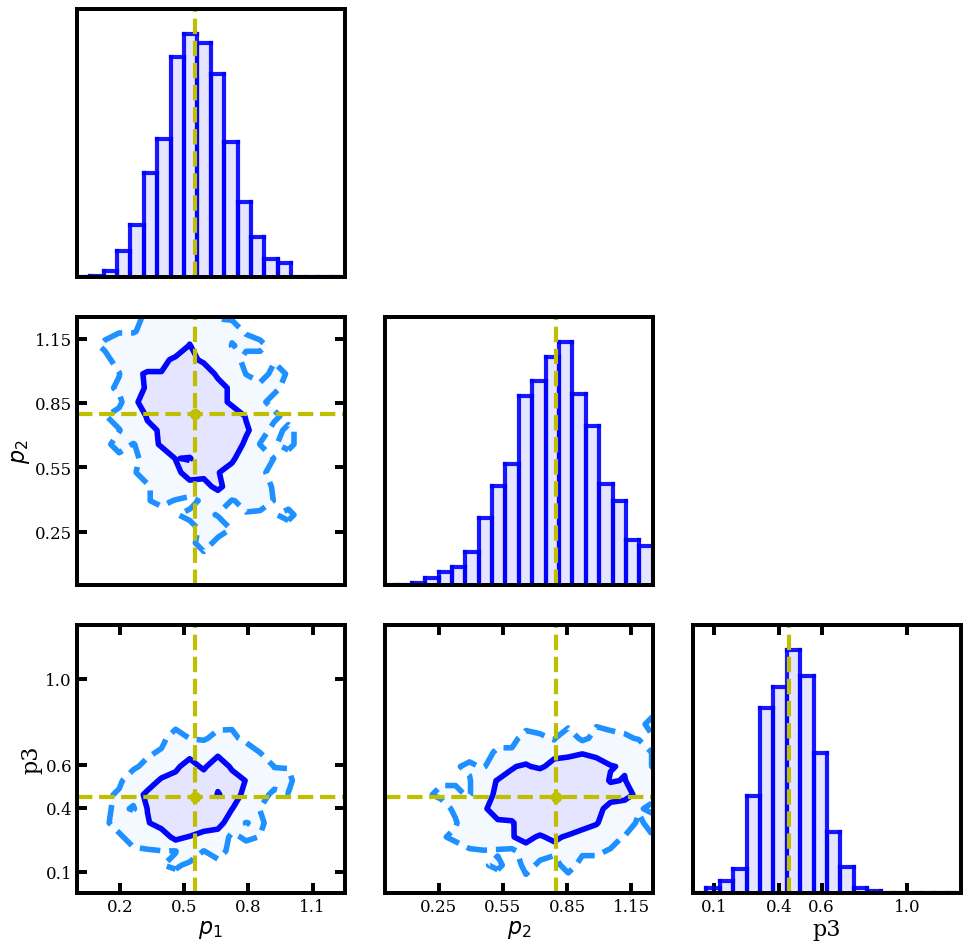

In [16]:
from matplotlib import colors

# these are stored as a private class attribute 

# this is what is in the code
# _default_contour_colors = [(colors.cnames['darkslategrey'], colors.cnames['black'], 'k'),
#                               (colors.cnames['dodgerblue'], colors.cnames['blue'], 'k'),
#                               (colors.cnames['orchid'], colors.cnames['darkviolet'], 'k'),
#                               (colors.cnames['lightcoral'], colors.cnames['red'], 'k'),
#                               (colors.cnames['orange'], colors.cnames['gold'], 'k')]
# truth_color = 'g'

triplot = TrianglePlot(pdf_list,
                      param_name_transformation=param_name_transformation,
                      ticks_and_labels_settings=ticks_and_labels_settings)

new_contour_colors = [(colors.cnames['dodgerblue'], colors.cnames['blue'], 'k'),
                      (colors.cnames['darkslategrey'], colors.cnames['black'], 'k'),
                               (colors.cnames['orchid'], colors.cnames['darkviolet'], 'k'),
                               (colors.cnames['lightcoral'], colors.cnames['red'], 'k'),
                               (colors.cnames['orange'], colors.cnames['gold'], 'k')]
new_truth_color = 'y'

# change the color scheme
triplot._default_contour_colors = new_contour_colors
triplot.truth_color = new_truth_color

contour_alpha = 0.1
axes_list = triplot.make_triplot(truths=truths,
                                show_intervals=False,
                                contour_alpha=contour_alpha)